In [138]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,root_mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from itertools import product
from skforecast.sarimax import Sarimax
from skforecast.recursive import ForecasterSarimax
from skforecast.model_selection import backtesting_sarimax, grid_search_sarimax
from skforecast.model_selection import TimeSeriesFold
from statsmodels.tsa.statespace.sarimax import SARIMAX

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


In [139]:
df = pd.read_csv(r'..\..\data\processed\Merch_ML.csv',index_col='Order_ID')
df.head()

,Order_Date,Buyer_Age,Sales_Price,Shipping_Charges,Sales_per_Unit,Quantity,Total_Sales,Rating,Product_ID,Order_Location,International_Shipping,Buyer_Gender,Product_Category_Clothing,Product_Category_Ornaments,Product_Category_Other
Order_ID,,,,,,,,,,,,,,,
189440,2024-07-21,30,100,0,100,1,100,4,0,15,0,1,1.0,0.0,0.0
187385,2024-07-20,32,100,0,100,1,100,3,0,6,0,1,1.0,0.0,0.0
181844,2024-07-21,26,9,40,49,1,49,2,1,1,1,0,0.0,0.0,1.0
197934,2024-08-19,28,9,0,9,2,18,3,1,18,0,1,0.0,0.0,1.0
122470,2024-01-06,19,10,0,10,3,30,5,2,11,0,0,0.0,0.0,1.0


In [140]:
df['Order_Date'] = pd.to_datetime(df['Order_Date'])

In [141]:
df.drop(df[(df['Order_Date'].dt.month == 11) & (df['Order_Date'].dt.year == 2024)].index,axis=0,inplace=True)

In [142]:
# Asegurar que las fechas sean de tipo datetime
df['Order_Date'] = pd.to_datetime(df['Order_Date'])

df_daily = df.groupby(df['Order_Date'].dt.to_period('D'))['Total_Sales'].sum().reset_index()

df_daily['Order_Date'] = df_daily['Order_Date'].dt.to_timestamp()

df_daily.head()


,Order_Date,Total_Sales
0,2023-11-05,1954
1,2023-11-06,2007
2,2023-11-07,2652
3,2023-11-08,1651
4,2023-11-09,1982


In [143]:
df_daily.set_index('Order_Date',inplace=True)

In [144]:
df_daily.sort_values(by='Order_Date')

,Total_Sales
Order_Date,
2023-11-05,1954
2023-11-06,2007
2023-11-07,2652
2023-11-08,1651
2023-11-09,1982
...,...
2024-10-27,1490
2024-10-28,1205
2024-10-29,2226


In [145]:
df_daily = df_daily.asfreq('D')

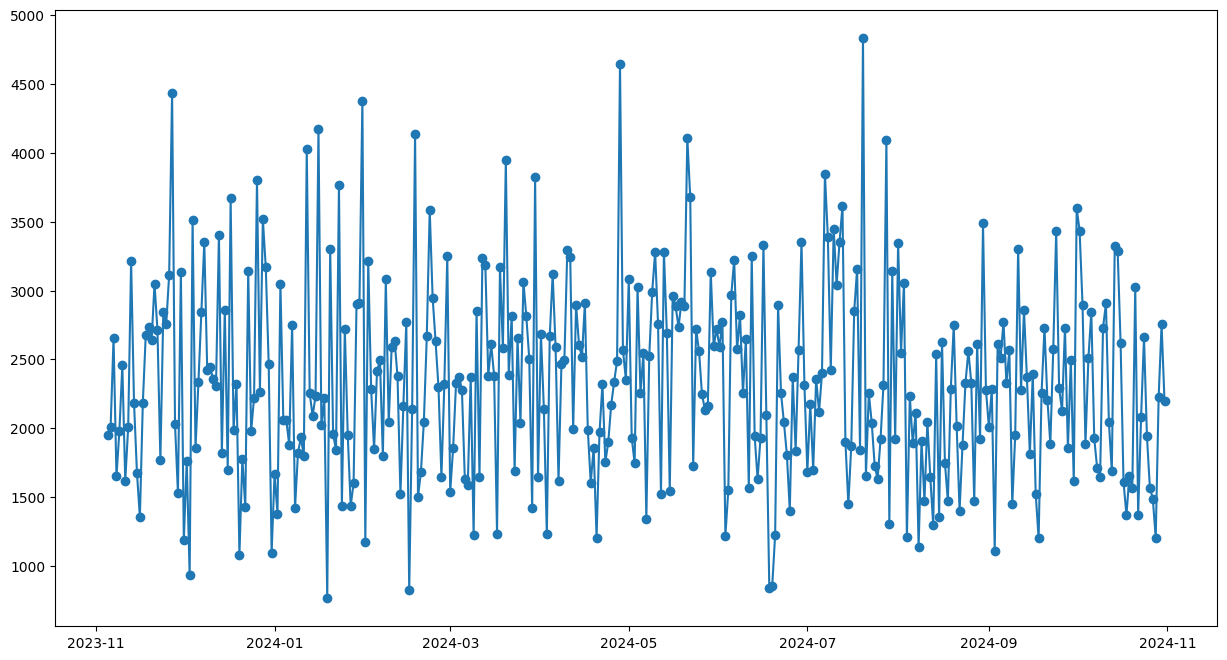

In [146]:
plt.figure(figsize=(15,8))
plt.plot(df_daily.index, df_daily['Total_Sales'], label='Ventas Reales', marker='o');

In [147]:
print(type(df_daily.index))

<class 'pandas.core.indexes.datetimes.DatetimeIndex'>


In [148]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df_daily['Total_Sales'])
print(f"p-value de Dickey-Fuller: {result[1]:.5f}")

# Interpretación:
if result[1] < 0.05:
    print("La serie es estacionaria (p-value < 0.05)")
else:
    print("La serie NO es estacionaria (p-value >= 0.05), necesitamos diferenciación.")


p-value de Dickey-Fuller: 0.00000
La serie es estacionaria (p-value < 0.05)


In [149]:
print(f"Número de observaciones en df_monthly: {len(df_daily)}")


Número de observaciones en df_monthly: 362


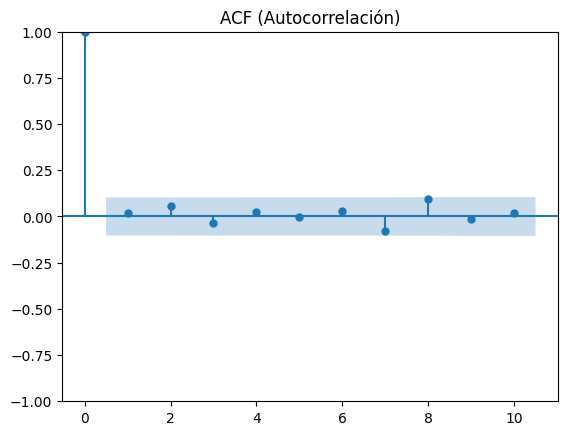

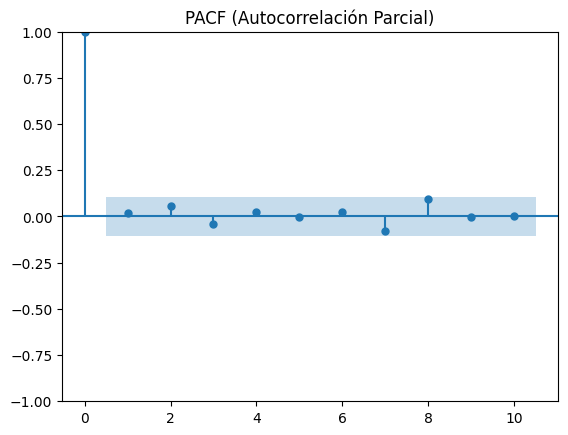

In [150]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df_daily['Total_Sales'].dropna(), lags=10)  # Ver ACF para determinar `q`
plt.title('ACF (Autocorrelación)')

plot_pacf(df_daily['Total_Sales'].dropna(), lags=10)  # Ver PACF para determinar `p`
plt.title('PACF (Autocorrelación Parcial)')

plt.show()


In [151]:
train = df_daily.iloc[:290]
test = df_daily.iloc[290:]

print(f"Tamaño de Train: {len(train)} dias")
print(f"Tamaño de Test: {len(test)} dias")


Tamaño de Train: 290 dias
Tamaño de Test: 72 dias


In [155]:
model = ARIMA(train['Total_Sales'], order=(1,0,1)).fit()

# Hacer predicciones en el conjunto de Test
test_pred = model.forecast(steps=len(test))

# Calcular el error en Test
mae = mean_absolute_error(test, test_pred)
print(f"Error MAE en Test: {mae:.2f}")

Error MAE en Test: 509.24


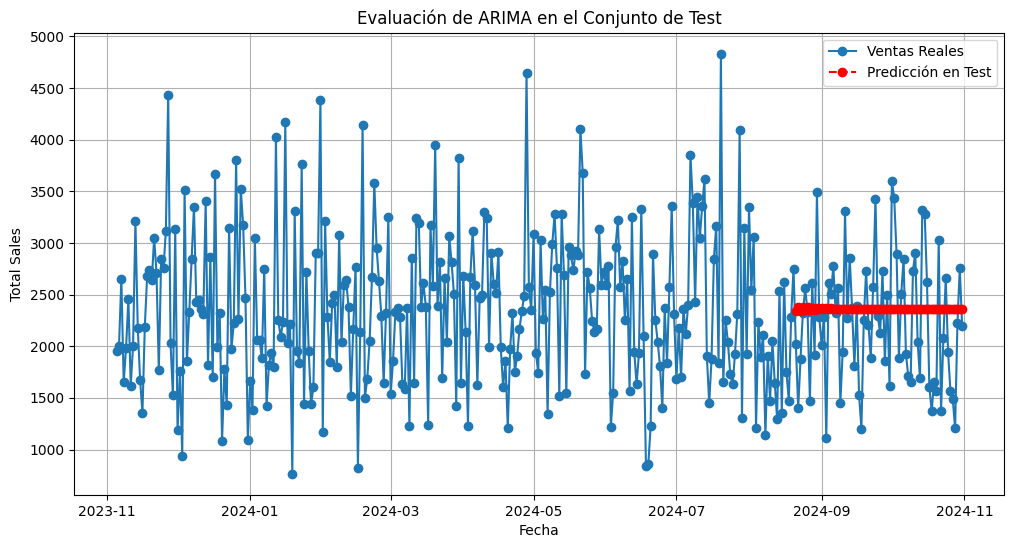

In [156]:
plt.figure(figsize=(12,6))

# Graficar las ventas reales
plt.plot(df_daily.index, df_daily['Total_Sales'], label='Ventas Reales', marker='o')

# Graficar predicciones en Test
plt.plot(test.index, test_pred, label='Predicción en Test', linestyle='dashed', marker='o', color='red')

# Configurar la gráfica
plt.xlabel('Fecha')
plt.ylabel('Total Sales')
plt.title('Evaluación de ARIMA en el Conjunto de Test')
plt.legend()
plt.grid()
plt.show()


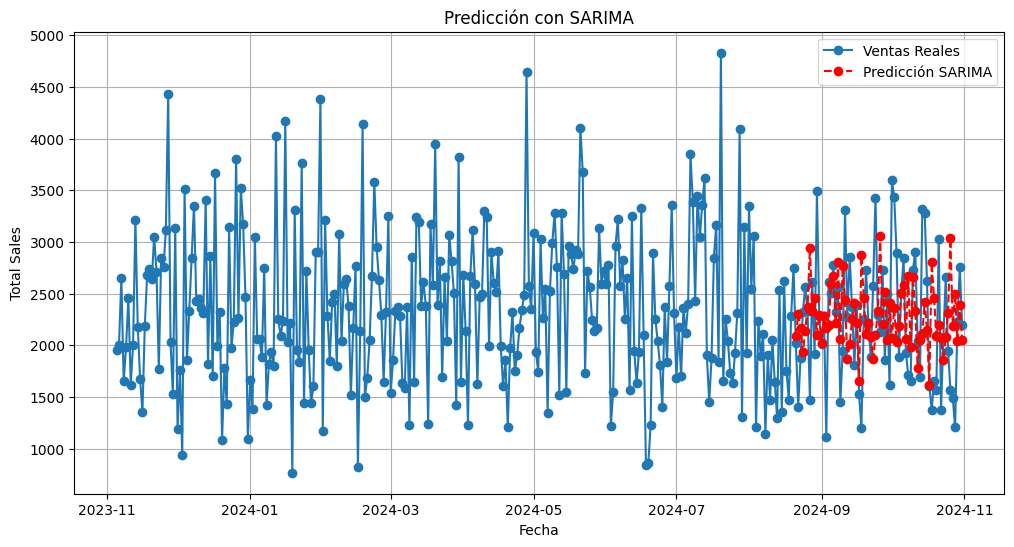

In [177]:
model_sarima = SARIMAX(train['Total_Sales'], order=(0,0,2), seasonal_order=(1,0,2,30)).fit()
test_pred_sarima = model_sarima.forecast(steps=len(test))

plt.figure(figsize=(12,6))
plt.plot(df_daily.index, df_daily['Total_Sales'], label='Ventas Reales', marker='o')
plt.plot(test.index, test_pred_sarima, label='Predicción SARIMA', linestyle='dashed', marker='o', color='red')
plt.xlabel('Fecha')
plt.ylabel('Total Sales')
plt.title('Predicción con SARIMA')
plt.legend()
plt.grid()
plt.show();

In [178]:
mae = mean_absolute_error(test,test_pred_sarima)
rmse = root_mean_squared_error(test,test_pred_sarima)

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 548.15
RMSE: 704.38


In [161]:
forecaster = ForecasterSarimax(
    regressor=Sarimax(
        order=(1, 1, 0),  # Hiperparámetros del modelo (p, d, q)
        seasonal_order=(0, 0, 0, 30),  # Hiperparámetros estacionales (P, D, Q, S)
        maxiter=200  # Número máximo de iteraciones
    )
)

# Definir la validación cruzada con TimeSeriesFold
cv = TimeSeriesFold(
    steps=12,
    initial_train_size=len(df_daily) - 12,  
    refit=True,  
    fixed_train_size=False  
)

metrica, predicciones_sarimax_f = backtesting_sarimax(
    forecaster=forecaster,
    y=df_daily['Total_Sales'],  # La variable objetivo (ventas)
    cv=cv,
    metric='mean_absolute_error',
    suppress_warnings_fit=True,
    verbose=True,
    show_progress=True
)

print(f'Metrica: {metrica}')
print(f'Predicciones:\n{predicciones_sarimax_f.head()}')

Information of folds
--------------------
Number of observations used for initial training: 350
Number of observations used for backtesting: 12
    Number of folds: 1
    Number skipped folds: 0 
    Number of steps per fold: 12
    Number of steps to exclude between last observed data (last window) and predictions (gap): 0

Fold: 0
    Training:   2023-11-05 00:00:00 -- 2024-10-19 00:00:00  (n=350)
    Validation: 2024-10-20 00:00:00 -- 2024-10-31 00:00:00  (n=12)



100%|██████████| 1/1 [00:00<00:00, 332.43it/s]

Metrica:    mean_absolute_error
0           552.666502
Predicciones:
                   pred
2024-10-20  1505.422382
2024-10-21  1581.111107
2024-10-22  1541.759020
2024-10-23  1562.218959
2024-10-24  1551.581426


In [164]:
forecaster = ForecasterSarimax(
                 regressor=Sarimax(
                                order=(1, 0, 1),
                                maxiter=500
                            )
             )

p_range = range(2)
d_range = range(0,1)
q_range = range(2)
P_range = range(2) 
D_range = range(2) 
Q_range = range(2) 
m_values = range(28,30)
# Generar todas las combinaciones posibles para order y seasonal_order
param_grid = {
    'order': [(p, d, q) for p, d, q in product(p_range, d_range, q_range)],
    'seasonal_order': [(P, D, Q, m) for P, D, Q, m in product(P_range, D_range, Q_range, m_values)]
}

cv = TimeSeriesFold(
        steps              = 12,
        initial_train_size = len(df_daily) - 12,
        refit              = True,
        fixed_train_size   = False,
    )


resultados_grid = grid_search_sarimax(
                        forecaster            = forecaster,
                        y                     = df_daily['Total_Sales'],
                        param_grid            = param_grid,
                        cv                    = cv,
                        metric                = 'mean_absolute_error',
                        return_best           = True,
                        n_jobs                = 'auto',
                        suppress_warnings_fit = True,
                        verbose               = False,
                        show_progress         = True
                   )
resultados_grid.head()

Number of models compared: 64.


params grid: 100%|██████████| 64/64 [01:17<00:00,  1.21s/it]


`Forecaster` refitted using the best-found parameters, and the whole data set: 
  Parameters: {'order': (0, 0, 1), 'seasonal_order': (1, 0, 0, 28)}
  Backtesting metric: 517.0722892159401



,params,mean_absolute_error,order,seasonal_order
0,"{'order': (0, 0, 1), 'seasonal_order': (1, 0, ...",517.072289,"(0, 0, 1)","(1, 0, 0, 28)"
1,"{'order': (1, 0, 1), 'seasonal_order': (1, 0, ...",536.867734,"(1, 0, 1)","(1, 0, 1, 28)"
2,"{'order': (0, 0, 0), 'seasonal_order': (1, 0, ...",564.344308,"(0, 0, 0)","(1, 0, 0, 28)"
3,"{'order': (1, 0, 1), 'seasonal_order': (0, 0, ...",564.596694,"(1, 0, 1)","(0, 0, 1, 28)"
4,"{'order': (1, 0, 1), 'seasonal_order': (0, 0, ...",565.076304,"(1, 0, 1)","(0, 0, 0, 29)"


In [179]:
# Obtener los residuos
residuals = model_sarima.resid

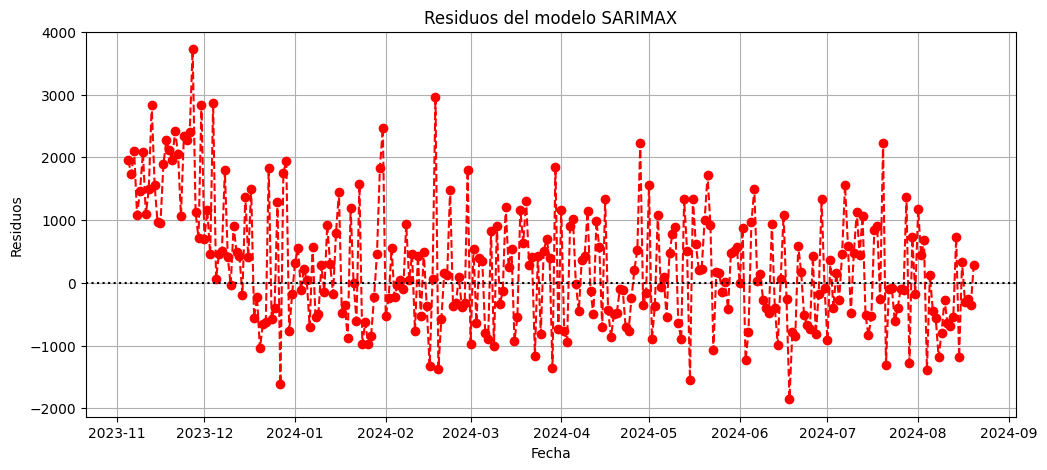

In [180]:
plt.figure(figsize=(12,5))
plt.plot(residuals, marker='o', linestyle='dashed', color='red')
plt.axhline(y=0, color='black', linestyle='dotted')
plt.title('Residuos del modelo SARIMAX')
plt.xlabel('Fecha')
plt.ylabel('Residuos')
plt.grid()
plt.show()


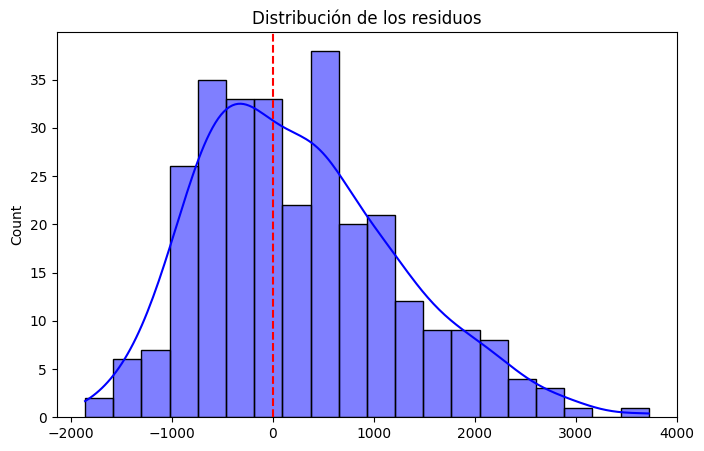

In [181]:
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=20, kde=True, color='blue')
plt.axvline(x=0, color='red', linestyle='dashed')
plt.title('Distribución de los residuos')
plt.show()

In [182]:
from scipy.stats import shapiro

stat, p = shapiro(residuals)
print(f'Estadística={stat:.4f}, p-valor={p:.4f}')

if p > 0.05:
    print("✅ Los residuos siguen una distribución normal (p > 0.05)")
else:
    print("❌ Los residuos NO siguen una distribución normal (p < 0.05)")


Estadística=0.9724, p-valor=0.0000
❌ Los residuos NO siguen una distribución normal (p < 0.05)


### XGBoost

In [183]:
df_daily['year'] = df_daily.index.year
df_daily['month'] = df_daily.index.month
df_daily['weekofyear'] = df_daily.index.isocalendar().week  # Para semanas del año
df_daily['dayofweek'] = df_daily.index.dayofweek  # 0 = Lunes, 6 = Domingo
df_daily['is_weekend'] = (df_daily['dayofweek'] >= 5).astype(int)  # 1 = Fin de semana


In [184]:
df_daily['sales_lag_1'] = df_daily['Total_Sales'].shift(1)  # Ventas de la semana anterior
df_daily['sales_lag_2'] = df_daily['Total_Sales'].shift(2)  # Ventas de hace 2 semanas
df_daily['sales_lag_3'] = df_daily['Total_Sales'].shift(3)  # Ventas de hace 3 semanas

df_daily['rolling_mean_4'] = df_daily['Total_Sales'].shift(1).rolling(window=4).mean()  # Media móvil 4 semanas

In [185]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

In [192]:
df_daily.fillna(np.mean(df_daily['Total_Sales']),inplace=True)

In [195]:
train = df_daily.iloc[:290]
test = df_daily.iloc[290:]

In [200]:
X_train, y_train = train.drop(columns=['Total_Sales']), train['Total_Sales']
X_test, y_test = test.drop(columns=['Total_Sales']), test['Total_Sales']

xgb = XGBRegressor(
    objective="reg:squarederror",
    learning_rate=0.01,
    max_depth=5,
    subsample=0.7,
    colsample_bytree=0.9)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

rmse = root_mean_squared_error(y_test,y_pred)
mae = mean_absolute_error(y_test,y_pred)
print(f'RMSE: {rmse:.4f}')
print(f'MAE: {mae:.4f}')

RMSE: 623.2504
MAE: 519.2029


In [32]:
X_test['Prediccion'] = y_pred